In [2]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from ast import literal_eval
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
import itertools
import tensorflow_datasets as tfds
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = 'learn-ai-bbc'
train = pd.read_csv(path+'/BBC News Train.csv')
test = pd.read_csv(path+'/BBC News Test.csv')

In [ ]:
##Exploratory Data Analysis

In [4]:
train['Category'].nunique() ## number of  categories

5

In [5]:
total_duplicate_titles = sum(train["Text"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")


There are 50 duplicate titles.


In [6]:
train = train[~train["Text"].duplicated()]
print(f"There are {len(train)} rows in the deduplicated dataset.")


There are 1440 rows in the deduplicated dataset.


(array([335.,   0., 234.,   0.,   0., 266.,   0., 342.,   0., 263.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

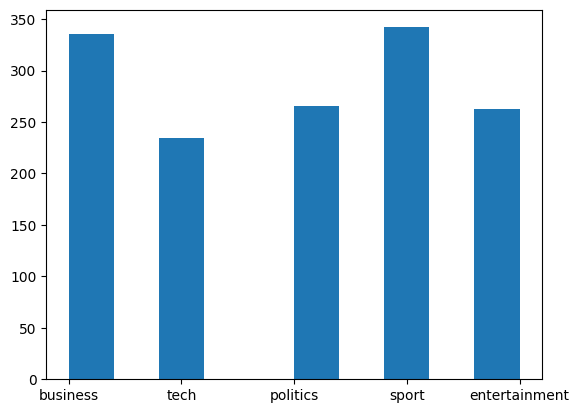

In [7]:
plt.hist(train['Category'])

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 1076 to 632
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1296 non-null   int64 
 1   Text       1296 non-null   object
 2   Category   1296 non-null   object
dtypes: int64(1), object(2)
memory usage: 40.5+ KB


In [12]:
train_df["Text"].apply(lambda x: len(x.split())).describe()


count    1296.000000
mean      387.431327
std       216.583325
min        90.000000
25%       251.750000
50%       340.000000
75%       472.500000
max      3345.000000
Name: Text, dtype: float64

In [231]:
## PERMUTATION CHECK Function as used in week 2
pd.set_option('future.no_silent_downcasting', True)
def permute_label(yp,label):

    k = list(train['Category'].unique())
    n = list(range(5))
    acc_cop = 0
    for i in itertools.permutations(n):
        d = dict(zip(k,i))
        l =  list(label.astype(str).replace(d,inplace=False))
        acc = sklearn.metrics.accuracy_score(l,yp )
        if acc_cop< acc:
            acc_cop = acc
            final_label_order = i
    #print(f"accuracy : {acc_cop}")
    #print(f"final_label : {final_label_order}")
    return acc_cop,final_label_order


In [233]:
# Use tf-idf features.
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20,
    stop_words="english", 
)
tfidf = tfidf_vectorizer.fit_transform(train.Text)

<em> Only use train data to find the correct label order. But later both will be used as concatenated series.

In [234]:
##model HIERARCHIAL
model = AgglomerativeClustering(n_clusters = 5)
label_model = model.fit(tfidf.toarray()).labels_
label = train['Category']
ac, final_label = permute_label(label_model,label)
print(f"accuracy : {ac}")
print(f"final_label : {final_label}")


accuracy : 0.8756944444444444
final_label : (3, 4, 1, 0, 2)


<EM>  Final label is used to calculate the test result. We also append the test dataset to retrain the model as this is unsupervised learning and we can do it to increase the data samples.

In [210]:
tfidf = tfidf_vectorizer.fit_transform(pd.concat([train['Text'],test['Text']]))
l = model.fit_predict(tfidf.toarray()).astype(str)
c=0
for i in final_label:
    l[l==str(i)] = train.Category.unique()[c]
    c+=1
test['Category'] = l[1440:]
test[['ArticleId','Category']].to_csv('Solution_Agglomerative.csv',index=False)
!kaggle competitions submit -c learn-ai-bbc -f Solution_Agglomerative.csv -m "Message"

100%|██████████████████████████████████████| 8.97k/8.97k [00:01<00:00, 8.74kB/s]
Successfully submitted to BBC News Classification

<b><center> <Big>TEST SET RESULT only with TRAIN DATA
<img src = 'Desktop/Screenshot 2024-05-15 at 5.41.08 AM.png' />
<b><center> TEST SET RESULT with TEST DATA
<img src = "Desktop/Screenshot 2024-05-15 at 7.46.20 AM.png" />



<em> The result on train set is good. The default metrics (linkage = ward, distance = euclidean)  was the best in week 2 assignment in the course so this is not changed. The test set result is poor but it's a multi-class problem so it is not too bad.

In [235]:
##MODEL KMEANS
# Use tf-idf features for NMF.
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20,
    stop_words="english",
    max_features = 1000
)
tfidf = tfidf_vectorizer.fit_transform(train['Text'])
l = []
for i in range(100):
    model = KMeans(n_clusters = 5, random_state = i).fit(tfidf)
    label_model = model.labels_
    
    label = train['Category']
    acc, final_label = permute_label(label_model,label)
    l.append([acc,final_label,model])
    
acc,final_label,model = sorted(l, key = lambda x:x[0])[-1]
print(f"accuracy",acc)
print(f"final_label",final_label)
                                                               

accuracy 0.9354166666666667
final_label (2, 3, 1, 4, 0)


<em> We change the random state as the Kmeans method is giving different results every time. Then we store the best model. The result on the train set is good. The final label is used to calculate the test set result as above and gives us much better result than hierarchial clustering

In [236]:
tfidf = tfidf_vectorizer.fit_transform(pd.concat([train['Text'],test['Text']]))
l = model.predict(tfidf.toarray()).astype(str)
c=0
for i in final_label:
    l[l==str(i)] = train.Category.unique()[c]
    c+=1
test['Category'] = l[1440:]
test[['ArticleId','Category']].to_csv('Solution_kMeans.csv',index=False)
!kaggle competitions submit -c learn-ai-bbc -f Solution_kMeans.csv -m "Message"

100%|██████████████████████████████████████| 8.96k/8.96k [00:01<00:00, 7.50kB/s]
Successfully submitted to BBC News Classification

<b><center> <Big>TEST SET RESULT
<img src = "Desktop/Screenshot 2024-05-15 at 8.07.10 AM.png"/>

<em> Both the unsupervised learning methods are similar in performance but Kmeans beats Hierarchial Clustering

In [150]:
def nmf_opt(tfidf_vectorizer,df1=None,Train=False):
    ## NMF optimizer function 

    """
    Parameters: 
    tfidf_vectorizer is the tfidf feature vector
    df1 is the test set  when train = false 
    and is none when train = True

    Return acc, label when train = true
    matrix W when df1 = Test
    """
    tfidf = tfidf_vectorizer.fit_transform(df1['Text'])
    C = csr_matrix(tfidf)
    X = sklearn.decomposition.NMF(n_components=5,solver='mu',init = 'nndsvda',
                                   beta_loss="kullback-leibler",alpha_W=0.00005,alpha_H=0.00005,
                                  l1_ratio=0.5,random_state =4).fit(C)
    W = (X.transform(C))
    W = np.array([W[i]==max(W[i]) for i in range(len(df1))])
    if Train :
        def label_permute_2(yp,Categ):
            l =[]
            for i in itertools.permutations(train["Category"].unique()):
                lookup = tf.keras.layers.StringLookup(vocabulary = i,output_mode="one_hot",num_oov_indices = 0)
                label_mh = [lookup(label).numpy() for label in Categ]
                l.append([sklearn.metrics.accuracy_score(yp,label_mh),i])
                return sorted(l,key = lambda x : x[0])[-1]
        out = label_permute_2(W,train['Category'].values)
    else:    
        out = W
    return out

In [151]:
l = []
## Find best parameters
for min_df,max_df,max_features in zip(range(1,100),np.arange(1,100)*0.01,np.arange(1,50)*100):
    tfidf_vectorizer = TfidfVectorizer(
    max_df=max_df,
    min_df=min_df,
    stop_words="english",
    max_features=max_features)
    acc, label_order = nmf_opt(tfidf_vectorizer,df1=train,Train=True) 
    l.append([acc,min_df,max_df,max_features])


In [152]:
print(F"Train set -- accuracy, min_df, max_df, max_features : {sorted(l,key = lambda x :x[0])[-1]}")
print(F"Label order -- :{label_order}")

Train set -- accuracy, min_df, max_df, max_features : [0.6270833333333333, 11, 0.11, 1100]
Label order -- :('business', 'tech', 'politics', 'sport', 'entertainment')


<em> The result seems sufficient on train set

In [154]:
## Check Test set
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.11,
    min_df=11,
    stop_words="english",
    max_features=max_features)
result = nmf_opt(tfidf_vectorizer,df1 = test)

In [155]:
arr_res = np.array([result[i]==max(result[i]) for i in range(len(result))]).astype(int)

In [156]:
yp = [np.take(label_order,np.argwhere(arr_res[i] == 1.0)[..., 0])[0] for i in range(len(result))]

In [157]:
test['Category'] = yp

In [158]:
test[['ArticleId','Category']].to_csv('Solution_NMF.csv',index=False)
!kaggle competitions submit -c learn-ai-bbc -f Solution_NMF.csv -m "Message"

100%|██████████████████████████████████████| 9.09k/9.09k [00:01<00:00, 8.29kB/s]
Successfully submitted to BBC News Classification

<b>  <center> <Big>  TEST SET RESULT
<img src = "Desktop/Screenshot 2024-05-15 at 5.35.22 AM.png" />


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score

max acc, neighbors [1.0, 1]
 acc, split [0.8715277777777778, 0.1]
 acc, split [0.9201388888888888, 0.30000000000000004]
 acc, split [0.9506944444444444, 0.5]
 acc, split [0.9791666666666666, 0.7000000000000001]
 acc, split [0.9895833333333334, 0.9]


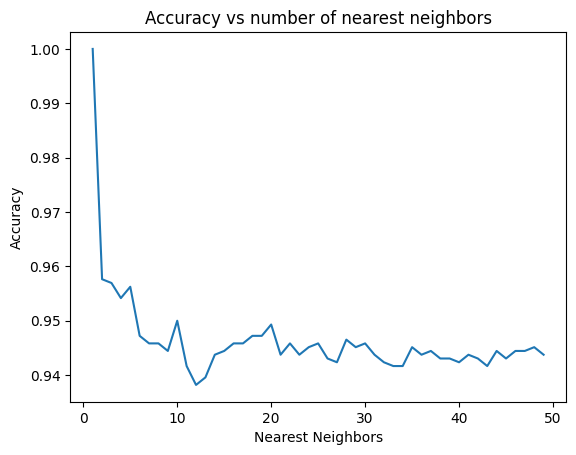

In [190]:
##use KNN on the data
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20,
    stop_words="english",
    max_features = 1000
)
tfidf = tfidf_vectorizer.fit_transform(train['Text'])
tfidf_test = tfidf_vectorizer.fit_transform(test['Text'])
##Check best value of number of nearest neighbors
l=[]
m=[]
for i in range(1,50):
    
    l.append([accuracy_score(sklearn.neighbors.KNeighborsClassifier(
        n_neighbors = i).fit(tfidf,train.Category).predict(tfidf),train.Category),i])
    m.append(accuracy_score(sklearn.neighbors.KNeighborsClassifier(
        n_neighbors = i).fit(tfidf,train.Category).predict(tfidf),train.Category))
print("max acc, neighbors" , (sorted(l,key =lambda x: x[0]))[-1])
nn = (sorted(l,key =lambda x: x[0]))[-1][1]
##Train splitting accuracy check
plt.plot(range(1,50),m)
plt.xlabel('Nearest Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of nearest neighbors')
for i in np.arange(1,11,2)*0.1:
    model = sklearn.neighbors.KNeighborsClassifier(
        n_neighbors = nn).fit(tfidf[:int(1440*i)],train.Category[:int(1440*i)])
    
    l = ([model.score(tfidf,train.Category),(i)])
    print(" acc, split" , l)

test['Category']= sklearn.neighbors.KNeighborsClassifier(n_neighbors = nn).fit(tfidf,train.Category).predict(tfidf_test)
test[['ArticleId','Category']].to_csv('Solution_KNN.csv',index=False)

<b> <center> <Big> TEST SET RESULT
<img src="Desktop/Screenshot 2024-05-15 at 5.32.37 AM.png"  />




<em> 50% data gives 95% accuracy on train set. The train set accuracy is 100. The test set result is similar to unsupervised learning result

In [75]:
##Use Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=20,
    stop_words="english",
    max_features = 1000
)
tfidf = tfidf_vectorizer.fit_transform(train['Text'])
tfidf_test = tfidf_vectorizer.fit_transform(test['Text'])
def build_dt(X,y,max_depth=None, max_leaf_nodes = None, ccp=0):
    clf=DecisionTreeClassifier(random_state=0,max_depth=max_depth,max_leaf_nodes=max_leaf_nodes,ccp_alpha=ccp)
    return clf.fit(X,y)
clf1 = build_dt(tfidf,train.Category)
print('acc = ' , accuracy_score(clf1.predict(tfidf),train.Category))

yp = (clf1.predict(tfidf_test))
test['Category'] = yp
test[['ArticleId','Category']].to_csv(path+'/Solution_clf.csv',index=False)

acc =  1.0


In [184]:
##Check accuracy by strength of train set splitting
for i in np.arange(1,11,2)*0.1:
    model = build_dt(tfidf[:int(1440*i)],train.Category[:int(1440*i)])
    
    l = ([model.score(tfidf,train.Category),(i)])
    print(" acc, split" , l)

 acc, split [0.6548611111111111, 0.1]
 acc, split [0.8173611111111111, 0.30000000000000004]
 acc, split [0.8847222222222222, 0.5]
 acc, split [0.9368055555555556, 0.7000000000000001]
 acc, split [0.9791666666666666, 0.9]


<b> <Center> <Big> TEST SET RESULT
<img src="Desktop/Screenshot 2024-05-15 at 4.07.43 AM.png"  />




<em> KNN works better than Decision Tree which overfits and uses 90% data to get more than 95% accuracy. The result is a little poor compared to unsupervised learning on the test set. The train set is completely fitted with 100% accuracy

In [ ]:
##Try and apply ccp_pruning but didn't get any change for first six test set result, so aborted.
dt = build_dt(tfidf, train.Category)

path = dt.cost_complexity_pruning_path(tfidf,train.Category) #post pruning
ccp_alphas, impurities = path.ccp_alphas, path.impurities


clfs = [] # VECTOR CONTAINING CLASSIFIERS FOR DIFFERENT ALPHAS
# TODO: iterate over ccp_alpha values 
for c in ccp_alphas:
    cl=build_dt(tfidf, train.Category,ccp=c)
    cl.fit(tfidf, train.Category)
    clfs.append(cl)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

# TODO: next, generate the train and test scores and plot the variation in these scores with increase in ccp_alpha
# The code for plotting has been provided; edit the train_scores and test_scores variables for the right plot to be generated
train_scores = [cl.score(tfidf,train.Category) for cl in clfs]
test_scores = []
##CCP pruning Trial does not work here
for cl in clfs:
    test['Category'] = cl.predict(tfidf_test)
    test[['ArticleId','Category']].to_csv('clf.csv',index=False)
    !kaggle competitions submit -c learn-ai-bbc -f clf.csv -m "Message"
    print('enter test acc')
    test_scores.append(float(input()))
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show() 


References:
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py